In [97]:
from mhadatareader import MhaDataReader
from classes import ParticipantsData, Scan, ProficiencyLabel, FoldSplit
import utils as ut
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools as it
import os 

In [108]:
ReferenceToTrackerTransform = np.array([-0.1232517738296135, 0.9599292571724247, 0.2516839714249816, 465.23671875,
              -0.7041061437955259, -0.2633116142251331, 0.6594706453539454, -17.1896484375,
              0.6993164795121365, -0.09593130374675335, 0.7083457111073661, -272.35546875, 
              0, 0, 0, 1]).reshape((4,4))

In [109]:
ProbeToTrackerTransform = np.array([0.02838116323914294, 0.09084585303069676, -0.995460466598407, 353.8096330914873,
                                    0.6749252497070167, 0.7328430466847913, 0.08612186849850533, -8.799462890582298,
                                    0.7373400958045847, -0.6743056428007094, -0.04051522190495802, -516.1651715960127,
                                    0, 0, 0, 1]).reshape((4,4))

In [111]:
ref_to_tracker_inv = np.linalg.inv(ReferenceToTrackerTransform)
prob_to_ref = ref_to_tracker_inv.dot(ProbeToTrackerTransform)
print(prob_to_ref.reshape(16, 1))

[[ 3.69170364e-02]
 [-9.98749252e-01]
 [ 3.37203692e-02]
 [-1.62674138e+02]
 [-2.21205745e-01]
 [-4.10734739e-02]
 [-9.74361836e-01]
 [-8.57823702e+01]
 [ 9.74528168e-01]
 [ 2.85114120e-02]
 [-2.22445383e-01]
 [-1.95212888e+02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.00000000e+00]]


In [98]:
DIR_NAME = './data_bckp'
MODEL_NAME = 'best_model'
slice_window = 500
print(slice_window)

500


In [99]:
def load_model(num, reg):
    build = True
    
    m_name_tuned = f'./best_model_tuned_{num}_{reg}.tf'
    if (os.path.exists(m_name_tuned)):
        print(f'loading prev tuned {m_name_tuned}')
        return keras.models.load_model(m_name_tuned), not build

    m_name_untuned = f'./best_model_{num}.tf'
    print(f'loading non-tuned {m_name_untuned}')
    return keras.models.load_model(m_name_untuned), build


def save_model(model, num, reg):
    m_name_tuned = f'./best_model_tuned_{num}_{reg}.tf'
    
    print(f'saving {m_name_tuned}')
    model.save(m_name_tuned)

In [72]:
novices, intermed, experts = ut.load_data(DIR_NAME)

In [73]:
models_train_hist = dict()
folds_stats = dict()

for i in range(6):
    models_train_hist[i] = dict()
    folds_stats[i] = dict()
    for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
        models_train_hist[i][reg] = dict()
        folds_stats[i][reg] = []

In [74]:
# hyper-parameters #
epochs = 300
batch_size = 32
kernel_size = 5
filters = 64
dropout_rate = 0.5
learning_rate = 0.00001
regularizer = keras.regularizers.l1_l2(0.05)
CALLBACKS = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=20, min_lr=0.000001
    ),
]

In [95]:
def build_model_funetune(base_model, input_shape, num_classes, filters, 
                         kernel_size, dropout_rate, regularizer):
    assert base_model is not None
    model = keras.Sequential()
    
    # freeze the base model
    base_model.trainable = False
    # add all layers except the last two
    for layer in base_model.layers[:-2]: 
        model.add(layer)

    model.add(keras.layers.Conv1D(filters=filters, 
                            kernel_size=kernel_size, padding="same", 
                            kernel_regularizer=regularizer,
                            activation='relu',
                            name=f'Conv1D_{str(len(model.layers) + 1)}'))
    model.add(keras.layers.BatchNormalization(
        name=f'BatchNormalization_{str(len(model.layers) + 1)}'
    ))
    model.add(keras.layers.Dropout(dropout_rate,
                                  name=f'Dropout_{str(len(model.layers) + 1)}'
                                  ))

    model.add(keras.layers.GlobalAveragePooling1D(name=f'GlobalAveragePooling1D_{str(len(model.layers) + 1)}'))
    model.add(keras.layers.Dense(num_classes, activation='softmax',
                                 name=f'Dense_{str(len(model.layers) + 1)}'))
        
    model.compile(
                optimizer=keras.optimizers.Adam(
                    learning_rate=learning_rate
                ),
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])
    
    return model

## Regions

In [96]:
for _, reg in enumerate([Scan.LUQ, Scan.RUQ, Scan.PERICARD, Scan.PELVIC]):
    novices_reg, intermed_reg, experts_reg = ut.prepare_region(novices, intermed, experts, reg)
    folds_reg = ut.form_folds(novices_reg, intermed_reg, experts_reg)
    iterations = list(it.permutations([i for i in range(len(folds_reg))]))
    
    for i in range(len(iterations)):
        train, valid, test = iterations[i]
        train, valid, test = folds_reg[train], folds_reg[valid], folds_reg[test]
        train, valid, test = ut.prepare_folds(train, valid, test, slice_window)

        x_train, y_train = train
        x_val, y_val = valid
        x_test, y_test = test
        
        print(f'Running fold on {reg} {i + 1}')
        print(f'Loading model {i} for region {reg}')
        model, build = load_model(i, reg.name)
        if build:
            print(f'building model {reg} {i}')
            model = build_model_funetune(
                model,
                x_train.shape[1:], 
                len(ProficiencyLabel), 
                kernel_size=kernel_size, 
                filters=filters, 
                dropout_rate=dropout_rate, 
                regularizer=regularizer,
            )
        
        
        history = model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=CALLBACKS,
            validation_data=(x_val, y_val),
            verbose=1,
        )
        models_train_hist[i][reg] = history.history

        test_loss, test_acc = model.evaluate(x_test, y_test)
        print(f'Test accuracy {reg}', test_acc)
        print(f'Test loss {reg}', test_loss)

        save_model(model, i, reg)

        folds_stats[i][reg].append((test_loss, test_acc))

Running fold on Scan.LUQ 1
Loading model 0 for region Scan.LUQ
loading non-tuned ./best_model_0.tf
building model Scan.LUQ 0
Epoch 1/300
92/92 [==============================] - 2s 12ms/step - loss: 51.6921 - sparse_categorical_accuracy: 0.3675 - val_loss: 50.9484 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/300
92/92 [==============================] - 1s 8ms/step - loss: 50.7150 - sparse_categorical_accuracy: 0.4327 - val_loss: 49.9581 - val_sparse_categorical_accuracy: 0.5957
Epoch 3/300
92/92 [==============================] - 1s 8ms/step - loss: 49.7854 - sparse_categorical_accuracy: 0.4198 - val_loss: 48.9914 - val_sparse_categorical_accuracy: 0.6001
Epoch 4/300
92/92 [==============================] - 1s 8ms/step - loss: 48.8479 - sparse_categorical_accuracy: 0.4615 - val_loss: 48.0491 - val_sparse_categorical_accuracy: 0.6001
Epoch 5/300
92/92 [==============================] - 1s 9ms/step - loss: 47.9102 - sparse_categorical_accuracy: 0.4681 - val_loss: 47.1184 - val_s

92/92 [==============================] - 1s 9ms/step - loss: 2.2441 - sparse_categorical_accuracy: 0.9687 - val_loss: 1.9475 - val_sparse_categorical_accuracy: 1.0000
Epoch 91/300
92/92 [==============================] - 1s 9ms/step - loss: 2.0801 - sparse_categorical_accuracy: 0.9807 - val_loss: 1.7990 - val_sparse_categorical_accuracy: 1.0000
Epoch 92/300
92/92 [==============================] - 1s 9ms/step - loss: 1.9216 - sparse_categorical_accuracy: 0.9863 - val_loss: 1.6576 - val_sparse_categorical_accuracy: 1.0000
Epoch 93/300
92/92 [==============================] - 1s 9ms/step - loss: 1.7571 - sparse_categorical_accuracy: 0.9858 - val_loss: 1.5242 - val_sparse_categorical_accuracy: 1.0000
Epoch 94/300
92/92 [==============================] - 1s 9ms/step - loss: 1.6392 - sparse_categorical_accuracy: 0.9838 - val_loss: 1.3954 - val_sparse_categorical_accuracy: 1.0000
Epoch 95/300
92/92 [==============================] - 1s 9ms/step - loss: 1.4989 - sparse_categorical_accuracy: 0

92/92 [==============================] - 1s 9ms/step - loss: 0.3232 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.3046 - val_sparse_categorical_accuracy: 1.0000
Epoch 181/300
92/92 [==============================] - 1s 9ms/step - loss: 0.3242 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.3039 - val_sparse_categorical_accuracy: 1.0000
Epoch 182/300
92/92 [==============================] - 1s 9ms/step - loss: 0.3207 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.3028 - val_sparse_categorical_accuracy: 1.0000
Epoch 183/300
92/92 [==============================] - 1s 9ms/step - loss: 0.3204 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.3030 - val_sparse_categorical_accuracy: 1.0000
Epoch 184/300
92/92 [==============================] - 1s 9ms/step - loss: 0.3154 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.3021 - val_sparse_categorical_accuracy: 1.0000
Epoch 185/300
92/92 [==============================] - 1s 9ms/step - loss: 0.3187 - sparse_categorical_accura

92/92 [==============================] - 1s 9ms/step - loss: 0.2831 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.2798 - val_sparse_categorical_accuracy: 1.0000
Epoch 271/300
92/92 [==============================] - 1s 9ms/step - loss: 0.2823 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.2802 - val_sparse_categorical_accuracy: 1.0000
Epoch 272/300
92/92 [==============================] - 1s 9ms/step - loss: 0.2850 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.2793 - val_sparse_categorical_accuracy: 1.0000
Epoch 273/300
92/92 [==============================] - 1s 9ms/step - loss: 0.2841 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.2791 - val_sparse_categorical_accuracy: 1.0000
Epoch 274/300
92/92 [==============================] - 1s 9ms/step - loss: 0.2855 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.2785 - val_sparse_categorical_accuracy: 1.0000
Epoch 275/300
92/92 [==============================] - 1s 9ms/step - loss: 0.2842 - sparse_categorical_accura

Epoch 13/300
92/92 [==============================] - 1s 8ms/step - loss: 40.4903 - sparse_categorical_accuracy: 0.5375 - val_loss: 39.9455 - val_sparse_categorical_accuracy: 0.4060
Epoch 14/300
92/92 [==============================] - 1s 9ms/step - loss: 39.6715 - sparse_categorical_accuracy: 0.5504 - val_loss: 39.0929 - val_sparse_categorical_accuracy: 0.5606
Epoch 15/300
92/92 [==============================] - 1s 9ms/step - loss: 38.8469 - sparse_categorical_accuracy: 0.5395 - val_loss: 38.2696 - val_sparse_categorical_accuracy: 0.6023
Epoch 16/300
92/92 [==============================] - 1s 8ms/step - loss: 38.0247 - sparse_categorical_accuracy: 0.5705 - val_loss: 37.4379 - val_sparse_categorical_accuracy: 0.6339
Epoch 17/300
92/92 [==============================] - 1s 9ms/step - loss: 37.2215 - sparse_categorical_accuracy: 0.5882 - val_loss: 36.6249 - val_sparse_categorical_accuracy: 0.6499
Epoch 18/300
92/92 [==============================] - 1s 8ms/step - loss: 36.4261 - sparse

92/92 [==============================] - 1s 8ms/step - loss: 11.7473 - sparse_categorical_accuracy: 0.9298 - val_loss: 11.2041 - val_sparse_categorical_accuracy: 1.0000
Epoch 59/300
92/92 [==============================] - 1s 8ms/step - loss: 11.2811 - sparse_categorical_accuracy: 0.9415 - val_loss: 10.7701 - val_sparse_categorical_accuracy: 1.0000
Epoch 60/300
92/92 [==============================] - 1s 8ms/step - loss: 10.8875 - sparse_categorical_accuracy: 0.9216 - val_loss: 10.3474 - val_sparse_categorical_accuracy: 1.0000
Epoch 61/300
92/92 [==============================] - 1s 8ms/step - loss: 10.4372 - sparse_categorical_accuracy: 0.9475 - val_loss: 9.9363 - val_sparse_categorical_accuracy: 1.0000
Epoch 62/300
92/92 [==============================] - 1s 8ms/step - loss: 10.0575 - sparse_categorical_accuracy: 0.9269 - val_loss: 9.5317 - val_sparse_categorical_accuracy: 1.0000
Epoch 63/300
92/92 [==============================] - 1s 8ms/step - loss: 9.6478 - sparse_categorical_acc

92/92 [==============================] - 1s 8ms/step - loss: 0.2553 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2135 - val_sparse_categorical_accuracy: 1.0000
Epoch 149/300
92/92 [==============================] - 1s 7ms/step - loss: 0.2527 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2095 - val_sparse_categorical_accuracy: 1.0000
Epoch 150/300
92/92 [==============================] - 1s 7ms/step - loss: 0.2511 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.2138 - val_sparse_categorical_accuracy: 1.0000
Epoch 151/300
92/92 [==============================] - 1s 7ms/step - loss: 0.2506 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.2093 - val_sparse_categorical_accuracy: 1.0000
Epoch 152/300
92/92 [==============================] - 1s 8ms/step - loss: 0.2480 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2084 - val_sparse_categorical_accuracy: 1.0000
Epoch 153/300
92/92 [==============================] - 1s 7ms/step - loss: 0.2467 - sparse_categorical_accura

92/92 [==============================] - 1s 7ms/step - loss: 0.1811 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.1775 - val_sparse_categorical_accuracy: 1.0000
Epoch 239/300
92/92 [==============================] - 1s 7ms/step - loss: 0.1789 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.1789 - val_sparse_categorical_accuracy: 1.0000
Epoch 240/300
92/92 [==============================] - 1s 7ms/step - loss: 0.1788 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1784 - val_sparse_categorical_accuracy: 1.0000
Epoch 241/300
92/92 [==============================] - 1s 8ms/step - loss: 0.1774 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.1790 - val_sparse_categorical_accuracy: 1.0000
Epoch 242/300
92/92 [==============================] - 1s 7ms/step - loss: 0.1797 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.1765 - val_sparse_categorical_accuracy: 1.0000
Epoch 243/300
92/92 [==============================] - 1s 7ms/step - loss: 0.1770 - sparse_categorical_accura

Epoch 26/300
149/149 [==============================] - 1s 6ms/step - loss: 19.8252 - sparse_categorical_accuracy: 0.9939 - val_loss: 19.1394 - val_sparse_categorical_accuracy: 1.0000
Epoch 27/300
149/149 [==============================] - 1s 6ms/step - loss: 18.8755 - sparse_categorical_accuracy: 0.9963 - val_loss: 18.2161 - val_sparse_categorical_accuracy: 1.0000
Epoch 28/300
149/149 [==============================] - 1s 6ms/step - loss: 17.9454 - sparse_categorical_accuracy: 0.9973 - val_loss: 17.3085 - val_sparse_categorical_accuracy: 1.0000
Epoch 29/300
149/149 [==============================] - 1s 6ms/step - loss: 17.0554 - sparse_categorical_accuracy: 0.9968 - val_loss: 16.4274 - val_sparse_categorical_accuracy: 1.0000
Epoch 30/300
149/149 [==============================] - 1s 6ms/step - loss: 16.1912 - sparse_categorical_accuracy: 0.9968 - val_loss: 15.5668 - val_sparse_categorical_accuracy: 1.0000
Epoch 31/300
149/149 [==============================] - 1s 6ms/step - loss: 15.3

Epoch 71/300
149/149 [==============================] - 1s 6ms/step - loss: 0.2600 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.2409 - val_sparse_categorical_accuracy: 1.0000
Epoch 72/300
149/149 [==============================] - 1s 6ms/step - loss: 0.2566 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.2344 - val_sparse_categorical_accuracy: 1.0000
Epoch 73/300
149/149 [==============================] - 1s 6ms/step - loss: 0.2512 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.2314 - val_sparse_categorical_accuracy: 1.0000
Epoch 74/300
149/149 [==============================] - 1s 6ms/step - loss: 0.2589 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.2304 - val_sparse_categorical_accuracy: 1.0000
Epoch 75/300
149/149 [==============================] - 1s 6ms/step - loss: 0.2494 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.2304 - val_sparse_categorical_accuracy: 1.0000
Epoch 76/300
149/149 [==============================] - 1s 6ms/step - loss: 0.2504 - spars

Epoch 116/300
149/149 [==============================] - 1s 6ms/step - loss: 0.2140 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.1967 - val_sparse_categorical_accuracy: 1.0000
Epoch 117/300
149/149 [==============================] - 1s 6ms/step - loss: 0.2128 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.1965 - val_sparse_categorical_accuracy: 1.0000
Epoch 118/300
149/149 [==============================] - 1s 6ms/step - loss: 0.2072 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.1961 - val_sparse_categorical_accuracy: 1.0000
Epoch 119/300
149/149 [==============================] - 1s 6ms/step - loss: 0.2065 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.1954 - val_sparse_categorical_accuracy: 1.0000
Epoch 120/300
149/149 [==============================] - 1s 6ms/step - loss: 0.2098 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.1954 - val_sparse_categorical_accuracy: 1.0000
Epoch 121/300
149/149 [==============================] - 1s 6ms/step - loss: 0.2071 -

Epoch 161/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1934 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.1838 - val_sparse_categorical_accuracy: 1.0000
Epoch 162/300
149/149 [==============================] - 1s 6ms/step - loss: 0.2041 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.1832 - val_sparse_categorical_accuracy: 1.0000
Epoch 163/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1928 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.1815 - val_sparse_categorical_accuracy: 1.0000
Epoch 164/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1975 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.1815 - val_sparse_categorical_accuracy: 1.0000
Epoch 165/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1952 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.1809 - val_sparse_categorical_accuracy: 1.0000
Epoch 166/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1901 -

Epoch 206/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1851 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.1757 - val_sparse_categorical_accuracy: 1.0000
Epoch 207/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1838 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.1767 - val_sparse_categorical_accuracy: 1.0000
Epoch 208/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1885 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.1749 - val_sparse_categorical_accuracy: 1.0000
Epoch 209/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1841 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.1746 - val_sparse_categorical_accuracy: 1.0000
Epoch 210/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1839 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.1744 - val_sparse_categorical_accuracy: 1.0000
Epoch 211/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1851 -

Epoch 251/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1805 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.1730 - val_sparse_categorical_accuracy: 1.0000
Epoch 252/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1820 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.1724 - val_sparse_categorical_accuracy: 1.0000
Epoch 253/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1797 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.1713 - val_sparse_categorical_accuracy: 1.0000
Epoch 254/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1860 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.1716 - val_sparse_categorical_accuracy: 1.0000
Epoch 255/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1804 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.1706 - val_sparse_categorical_accuracy: 1.0000
Epoch 256/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1815 -

Epoch 296/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1765 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.1684 - val_sparse_categorical_accuracy: 1.0000
Epoch 297/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1792 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.1698 - val_sparse_categorical_accuracy: 1.0000
Epoch 298/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1774 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.1713 - val_sparse_categorical_accuracy: 1.0000
Epoch 299/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1869 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.1713 - val_sparse_categorical_accuracy: 1.0000
Epoch 300/300
122/122 [==============================] - 0s 2ms/step - loss: 0.1687 - sparse_categorical_accuracy: 1.0000
Test accuracy Scan.LUQ 1.0
Test loss Scan.LUQ 0.16867974400520325
saving ./best_model_tuned_2_Scan.LUQ.tf
INFO:tensorflow:Assets written to: ./bes

149/149 [==============================] - 1s 7ms/step - loss: 0.2519 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.2071 - val_sparse_categorical_accuracy: 1.0000
Epoch 84/300
149/149 [==============================] - 1s 7ms/step - loss: 0.2471 - sparse_categorical_accuracy: 0.9949 - val_loss: 0.2059 - val_sparse_categorical_accuracy: 1.0000
Epoch 85/300
149/149 [==============================] - 1s 7ms/step - loss: 0.2404 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.2048 - val_sparse_categorical_accuracy: 1.0000
Epoch 86/300
149/149 [==============================] - 1s 7ms/step - loss: 0.2338 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.2058 - val_sparse_categorical_accuracy: 1.0000
Epoch 87/300
149/149 [==============================] - 1s 7ms/step - loss: 0.2429 - sparse_categorical_accuracy: 0.9956 - val_loss: 0.2045 - val_sparse_categorical_accuracy: 1.0000
Epoch 88/300
149/149 [==============================] - 1s 7ms/step - loss: 0.2396 - sparse_categorical

Epoch 128/300
149/149 [==============================] - 1s 7ms/step - loss: 0.2142 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.1845 - val_sparse_categorical_accuracy: 1.0000
Epoch 129/300
149/149 [==============================] - 1s 7ms/step - loss: 0.2121 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.1817 - val_sparse_categorical_accuracy: 1.0000
Epoch 130/300
149/149 [==============================] - 1s 7ms/step - loss: 0.2040 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.1822 - val_sparse_categorical_accuracy: 1.0000
Epoch 131/300
149/149 [==============================] - 1s 7ms/step - loss: 0.2066 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.1817 - val_sparse_categorical_accuracy: 1.0000
Epoch 132/300
149/149 [==============================] - 1s 7ms/step - loss: 0.2009 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.1818 - val_sparse_categorical_accuracy: 1.0000
Epoch 133/300
149/149 [==============================] - 1s 8ms/step - loss: 0.2052 -

Epoch 173/300
149/149 [==============================] - 1s 7ms/step - loss: 0.1922 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.1730 - val_sparse_categorical_accuracy: 1.0000
Epoch 174/300
149/149 [==============================] - 1s 7ms/step - loss: 0.1932 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.1737 - val_sparse_categorical_accuracy: 1.0000
Epoch 175/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1936 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.1724 - val_sparse_categorical_accuracy: 1.0000
Epoch 176/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1936 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.1748 - val_sparse_categorical_accuracy: 1.0000
Epoch 177/300
149/149 [==============================] - 1s 7ms/step - loss: 0.1922 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.1742 - val_sparse_categorical_accuracy: 1.0000
Epoch 178/300
149/149 [==============================] - 1s 6ms/step - loss: 0.1930 -

Epoch 218/300
149/149 [==============================] - 1s 7ms/step - loss: 0.1802 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.1680 - val_sparse_categorical_accuracy: 1.0000
Epoch 219/300
149/149 [==============================] - 1s 7ms/step - loss: 0.1874 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.1667 - val_sparse_categorical_accuracy: 1.0000
Epoch 220/300
149/149 [==============================] - 1s 7ms/step - loss: 0.1866 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.1669 - val_sparse_categorical_accuracy: 1.0000
Epoch 221/300
149/149 [==============================] - 1s 8ms/step - loss: 0.1821 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.1690 - val_sparse_categorical_accuracy: 1.0000
Epoch 222/300
149/149 [==============================] - 1s 7ms/step - loss: 0.1892 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.1676 - val_sparse_categorical_accuracy: 1.0000
Epoch 223/300
149/149 [==============================] - 1s 7ms/step - loss: 0.1856 -

Epoch 263/300
149/149 [==============================] - 1s 7ms/step - loss: 0.1792 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.1645 - val_sparse_categorical_accuracy: 1.0000
Epoch 264/300
149/149 [==============================] - 1s 7ms/step - loss: 0.1860 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.1636 - val_sparse_categorical_accuracy: 1.0000
Epoch 265/300
149/149 [==============================] - 1s 7ms/step - loss: 0.1796 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.1635 - val_sparse_categorical_accuracy: 1.0000
Epoch 266/300
149/149 [==============================] - 1s 7ms/step - loss: 0.1751 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.1695 - val_sparse_categorical_accuracy: 1.0000
Epoch 267/300
149/149 [==============================] - 1s 7ms/step - loss: 0.1762 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.1630 - val_sparse_categorical_accuracy: 1.0000
Epoch 268/300
149/149 [==============================] - 1s 7ms/step - loss: 0.1785 -

Epoch 50/300
122/122 [==============================] - 1s 6ms/step - loss: 8.4703 - sparse_categorical_accuracy: 0.9397 - val_loss: 7.9942 - val_sparse_categorical_accuracy: 1.0000
Epoch 51/300
122/122 [==============================] - 1s 6ms/step - loss: 7.9651 - sparse_categorical_accuracy: 0.9477 - val_loss: 7.5214 - val_sparse_categorical_accuracy: 1.0000
Epoch 52/300
122/122 [==============================] - 1s 6ms/step - loss: 7.4913 - sparse_categorical_accuracy: 0.9611 - val_loss: 7.0661 - val_sparse_categorical_accuracy: 1.0000
Epoch 53/300
122/122 [==============================] - 1s 6ms/step - loss: 7.0259 - sparse_categorical_accuracy: 0.9660 - val_loss: 6.6268 - val_sparse_categorical_accuracy: 1.0000
Epoch 54/300
122/122 [==============================] - 1s 6ms/step - loss: 6.6064 - sparse_categorical_accuracy: 0.9571 - val_loss: 6.1974 - val_sparse_categorical_accuracy: 1.0000
Epoch 55/300
122/122 [==============================] - 1s 6ms/step - loss: 6.1881 - spars

122/122 [==============================] - 1s 7ms/step - loss: 0.3242 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.3129 - val_sparse_categorical_accuracy: 1.0000
Epoch 96/300
122/122 [==============================] - 1s 7ms/step - loss: 0.3320 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.2964 - val_sparse_categorical_accuracy: 1.0000
Epoch 97/300
122/122 [==============================] - 1s 8ms/step - loss: 0.3228 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.2978 - val_sparse_categorical_accuracy: 1.0000
Epoch 98/300
122/122 [==============================] - 1s 8ms/step - loss: 0.3121 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.3031 - val_sparse_categorical_accuracy: 1.0000
Epoch 99/300
122/122 [==============================] - 1s 8ms/step - loss: 0.3136 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.3002 - val_sparse_categorical_accuracy: 1.0000
Epoch 100/300
122/122 [==============================] - 1s 8ms/step - loss: 0.3165 - sparse_categorica

Epoch 140/300
122/122 [==============================] - 1s 7ms/step - loss: 0.2212 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.2125 - val_sparse_categorical_accuracy: 1.0000
Epoch 141/300
122/122 [==============================] - 1s 7ms/step - loss: 0.2213 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.2092 - val_sparse_categorical_accuracy: 1.0000
Epoch 142/300
122/122 [==============================] - 1s 7ms/step - loss: 0.2195 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.2099 - val_sparse_categorical_accuracy: 1.0000
Epoch 143/300
122/122 [==============================] - 1s 7ms/step - loss: 0.2184 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.2058 - val_sparse_categorical_accuracy: 1.0000
Epoch 144/300
122/122 [==============================] - 1s 7ms/step - loss: 0.2187 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.2065 - val_sparse_categorical_accuracy: 1.0000
Epoch 145/300
122/122 [==============================] - 1s 7ms/step - loss: 0.2179 -

Epoch 185/300
122/122 [==============================] - 1s 6ms/step - loss: 0.1944 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.1845 - val_sparse_categorical_accuracy: 1.0000
Epoch 186/300
122/122 [==============================] - 1s 6ms/step - loss: 0.1992 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.1861 - val_sparse_categorical_accuracy: 1.0000
Epoch 187/300
122/122 [==============================] - 1s 6ms/step - loss: 0.1955 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.1846 - val_sparse_categorical_accuracy: 1.0000
Epoch 188/300
122/122 [==============================] - 1s 6ms/step - loss: 0.1936 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.1838 - val_sparse_categorical_accuracy: 1.0000
Epoch 189/300
122/122 [==============================] - 1s 6ms/step - loss: 0.1936 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.1847 - val_sparse_categorical_accuracy: 1.0000
Epoch 190/300
122/122 [==============================] - 1s 6ms/step - loss: 0.1942 -

Epoch 230/300
122/122 [==============================] - 1s 7ms/step - loss: 0.1857 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.1752 - val_sparse_categorical_accuracy: 1.0000
Epoch 231/300
122/122 [==============================] - 1s 7ms/step - loss: 0.1861 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.1752 - val_sparse_categorical_accuracy: 1.0000
Epoch 232/300
122/122 [==============================] - 1s 7ms/step - loss: 0.1846 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.1753 - val_sparse_categorical_accuracy: 1.0000
Epoch 233/300
122/122 [==============================] - 1s 7ms/step - loss: 0.1858 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.1748 - val_sparse_categorical_accuracy: 1.0000
Epoch 234/300
122/122 [==============================] - 1s 8ms/step - loss: 0.1887 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.1767 - val_sparse_categorical_accuracy: 1.0000
Epoch 235/300
122/122 [==============================] - 1s 8ms/step - loss: 0.1857 -

Epoch 275/300
122/122 [==============================] - 1s 6ms/step - loss: 0.1796 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.1715 - val_sparse_categorical_accuracy: 1.0000
Epoch 276/300
122/122 [==============================] - 1s 6ms/step - loss: 0.1787 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.1707 - val_sparse_categorical_accuracy: 1.0000
Epoch 277/300
122/122 [==============================] - 1s 6ms/step - loss: 0.1812 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.1704 - val_sparse_categorical_accuracy: 1.0000
Epoch 278/300
122/122 [==============================] - 1s 6ms/step - loss: 0.1837 - sparse_categorical_accuracy: 0.9961 - val_loss: 0.1699 - val_sparse_categorical_accuracy: 1.0000
Epoch 279/300
122/122 [==============================] - 1s 6ms/step - loss: 0.1782 - sparse_categorical_accuracy: 0.9986 - val_loss: 0.1697 - val_sparse_categorical_accuracy: 1.0000
Epoch 280/300
122/122 [==============================] - 1s 6ms/step - loss: 0.1776 -

Epoch 62/300
122/122 [==============================] - 1s 7ms/step - loss: 3.5617 - sparse_categorical_accuracy: 0.9716 - val_loss: 3.2194 - val_sparse_categorical_accuracy: 1.0000
Epoch 63/300
122/122 [==============================] - 1s 7ms/step - loss: 3.2593 - sparse_categorical_accuracy: 0.9778 - val_loss: 2.9329 - val_sparse_categorical_accuracy: 1.0000
Epoch 64/300
122/122 [==============================] - 1s 8ms/step - loss: 2.9678 - sparse_categorical_accuracy: 0.9760 - val_loss: 2.6599 - val_sparse_categorical_accuracy: 1.0000
Epoch 65/300
122/122 [==============================] - 1s 7ms/step - loss: 2.6961 - sparse_categorical_accuracy: 0.9806 - val_loss: 2.4082 - val_sparse_categorical_accuracy: 1.0000
Epoch 66/300
122/122 [==============================] - 1s 7ms/step - loss: 2.4390 - sparse_categorical_accuracy: 0.9837 - val_loss: 2.1715 - val_sparse_categorical_accuracy: 1.0000
Epoch 67/300
122/122 [==============================] - 1s 7ms/step - loss: 2.2180 - spars

Epoch 107/300
122/122 [==============================] - 1s 9ms/step - loss: 0.2956 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.2559 - val_sparse_categorical_accuracy: 1.0000
Epoch 108/300
122/122 [==============================] - 1s 8ms/step - loss: 0.2884 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.2516 - val_sparse_categorical_accuracy: 1.0000
Epoch 109/300
122/122 [==============================] - 1s 8ms/step - loss: 0.2831 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.2533 - val_sparse_categorical_accuracy: 1.0000
Epoch 110/300
122/122 [==============================] - 1s 8ms/step - loss: 0.2857 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.2470 - val_sparse_categorical_accuracy: 1.0000
Epoch 111/300
122/122 [==============================] - 1s 8ms/step - loss: 0.2782 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.2456 - val_sparse_categorical_accuracy: 1.0000
Epoch 112/300
122/122 [==============================] - 1s 8ms/step - loss: 0.2754 -

Epoch 152/300
122/122 [==============================] - 1s 8ms/step - loss: 0.2215 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.2097 - val_sparse_categorical_accuracy: 1.0000
Epoch 153/300
122/122 [==============================] - 1s 8ms/step - loss: 0.2172 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.2096 - val_sparse_categorical_accuracy: 1.0000
Epoch 154/300
122/122 [==============================] - 1s 8ms/step - loss: 0.2186 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.2096 - val_sparse_categorical_accuracy: 1.0000
Epoch 155/300
122/122 [==============================] - 1s 8ms/step - loss: 0.2193 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.2087 - val_sparse_categorical_accuracy: 1.0000
Epoch 156/300
122/122 [==============================] - 1s 8ms/step - loss: 0.2175 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.2080 - val_sparse_categorical_accuracy: 1.0000
Epoch 157/300
122/122 [==============================] - 1s 8ms/step - loss: 0.2144 -

Epoch 197/300
122/122 [==============================] - 1s 8ms/step - loss: 0.2067 - sparse_categorical_accuracy: 0.9934 - val_loss: 0.1928 - val_sparse_categorical_accuracy: 1.0000
Epoch 198/300
122/122 [==============================] - 1s 7ms/step - loss: 0.2036 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.1941 - val_sparse_categorical_accuracy: 1.0000
Epoch 199/300
122/122 [==============================] - 1s 7ms/step - loss: 0.2043 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.1916 - val_sparse_categorical_accuracy: 1.0000
Epoch 200/300
122/122 [==============================] - 1s 7ms/step - loss: 0.1993 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.1917 - val_sparse_categorical_accuracy: 1.0000
Epoch 201/300
122/122 [==============================] - 1s 7ms/step - loss: 0.2007 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.1922 - val_sparse_categorical_accuracy: 1.0000
Epoch 202/300
122/122 [==============================] - 1s 7ms/step - loss: 0.2011 -

Epoch 242/300
122/122 [==============================] - 1s 7ms/step - loss: 0.1909 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.1851 - val_sparse_categorical_accuracy: 1.0000
Epoch 243/300
122/122 [==============================] - 1s 7ms/step - loss: 0.1950 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.1851 - val_sparse_categorical_accuracy: 1.0000
Epoch 244/300
122/122 [==============================] - 1s 7ms/step - loss: 0.1928 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.1838 - val_sparse_categorical_accuracy: 1.0000
Epoch 245/300
122/122 [==============================] - 1s 7ms/step - loss: 0.1948 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.1851 - val_sparse_categorical_accuracy: 1.0000
Epoch 246/300
122/122 [==============================] - 1s 7ms/step - loss: 0.1913 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.1850 - val_sparse_categorical_accuracy: 1.0000
Epoch 247/300
122/122 [==============================] - 1s 8ms/step - loss: 0.1934 -

72/72 [==============================] - 1s 10ms/step - loss: 33.0297 - sparse_categorical_accuracy: 0.8371 - val_loss: 32.3511 - val_sparse_categorical_accuracy: 1.0000
Epoch 29/300
72/72 [==============================] - 1s 11ms/step - loss: 32.4280 - sparse_categorical_accuracy: 0.8604 - val_loss: 31.7647 - val_sparse_categorical_accuracy: 1.0000
Epoch 30/300
72/72 [==============================] - 1s 10ms/step - loss: 31.8582 - sparse_categorical_accuracy: 0.8516 - val_loss: 31.1828 - val_sparse_categorical_accuracy: 1.0000
Epoch 31/300
72/72 [==============================] - 1s 11ms/step - loss: 31.2624 - sparse_categorical_accuracy: 0.8802 - val_loss: 30.6061 - val_sparse_categorical_accuracy: 1.0000
Epoch 32/300
72/72 [==============================] - 1s 11ms/step - loss: 30.6995 - sparse_categorical_accuracy: 0.8492 - val_loss: 30.0373 - val_sparse_categorical_accuracy: 1.0000
Epoch 33/300
72/72 [==============================] - 1s 14ms/step - loss: 30.1136 - sparse_catego

Epoch 73/300
72/72 [==============================] - 1s 13ms/step - loss: 11.8894 - sparse_categorical_accuracy: 0.9540 - val_loss: 11.4534 - val_sparse_categorical_accuracy: 1.0000
Epoch 74/300
72/72 [==============================] - 1s 13ms/step - loss: 11.5420 - sparse_categorical_accuracy: 0.9569 - val_loss: 11.1130 - val_sparse_categorical_accuracy: 1.0000
Epoch 75/300
72/72 [==============================] - 1s 13ms/step - loss: 11.2047 - sparse_categorical_accuracy: 0.9600 - val_loss: 10.7805 - val_sparse_categorical_accuracy: 1.0000
Epoch 76/300
72/72 [==============================] - 1s 13ms/step - loss: 10.8672 - sparse_categorical_accuracy: 0.9686 - val_loss: 10.4493 - val_sparse_categorical_accuracy: 1.0000
Epoch 77/300
72/72 [==============================] - 1s 13ms/step - loss: 10.5332 - sparse_categorical_accuracy: 0.9656 - val_loss: 10.1237 - val_sparse_categorical_accuracy: 1.0000
Epoch 78/300
72/72 [==============================] - 1s 13ms/step - loss: 10.1991 - 

72/72 [==============================] - 1s 13ms/step - loss: 0.3929 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.3559 - val_sparse_categorical_accuracy: 1.0000
Epoch 164/300
72/72 [==============================] - 1s 13ms/step - loss: 0.4052 - sparse_categorical_accuracy: 0.9892 - val_loss: 0.3518 - val_sparse_categorical_accuracy: 1.0000
Epoch 165/300
72/72 [==============================] - 1s 13ms/step - loss: 0.3936 - sparse_categorical_accuracy: 0.9956 - val_loss: 0.3505 - val_sparse_categorical_accuracy: 1.0000
Epoch 166/300
72/72 [==============================] - 1s 12ms/step - loss: 0.3979 - sparse_categorical_accuracy: 0.9942 - val_loss: 0.3480 - val_sparse_categorical_accuracy: 1.0000
Epoch 167/300
72/72 [==============================] - 1s 12ms/step - loss: 0.3880 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.3477 - val_sparse_categorical_accuracy: 1.0000
Epoch 168/300
72/72 [==============================] - 1s 12ms/step - loss: 0.3925 - sparse_categorical_

72/72 [==============================] - 1s 13ms/step - loss: 0.3201 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.2975 - val_sparse_categorical_accuracy: 1.0000
Epoch 254/300
72/72 [==============================] - 1s 13ms/step - loss: 0.3187 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.2973 - val_sparse_categorical_accuracy: 1.0000
Epoch 255/300
72/72 [==============================] - 1s 13ms/step - loss: 0.3239 - sparse_categorical_accuracy: 0.9922 - val_loss: 0.2973 - val_sparse_categorical_accuracy: 1.0000
Epoch 256/300
72/72 [==============================] - 1s 13ms/step - loss: 0.3215 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.2965 - val_sparse_categorical_accuracy: 1.0000
Epoch 257/300
72/72 [==============================] - 1s 13ms/step - loss: 0.3181 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.2969 - val_sparse_categorical_accuracy: 1.0000
Epoch 258/300
72/72 [==============================] - 1s 13ms/step - loss: 0.3153 - sparse_categorical_

72/72 [==============================] - 1s 14ms/step - loss: 26.4951 - sparse_categorical_accuracy: 0.9194 - val_loss: 25.9291 - val_sparse_categorical_accuracy: 0.9585
Epoch 41/300
72/72 [==============================] - 1s 13ms/step - loss: 25.9496 - sparse_categorical_accuracy: 0.9325 - val_loss: 25.4076 - val_sparse_categorical_accuracy: 0.9543
Epoch 42/300
72/72 [==============================] - 1s 14ms/step - loss: 25.4172 - sparse_categorical_accuracy: 0.9424 - val_loss: 24.8919 - val_sparse_categorical_accuracy: 0.9511
Epoch 43/300
72/72 [==============================] - 1s 14ms/step - loss: 24.8966 - sparse_categorical_accuracy: 0.9485 - val_loss: 24.3779 - val_sparse_categorical_accuracy: 0.9491
Epoch 44/300
72/72 [==============================] - 1s 14ms/step - loss: 24.3691 - sparse_categorical_accuracy: 0.9608 - val_loss: 23.8717 - val_sparse_categorical_accuracy: 0.9466
Epoch 45/300
72/72 [==============================] - 1s 13ms/step - loss: 23.8726 - sparse_catego

Epoch 85/300
72/72 [==============================] - 1s 14ms/step - loss: 7.9911 - sparse_categorical_accuracy: 0.9928 - val_loss: 7.7738 - val_sparse_categorical_accuracy: 0.9348
Epoch 86/300
72/72 [==============================] - 1s 14ms/step - loss: 7.7115 - sparse_categorical_accuracy: 0.9929 - val_loss: 7.4969 - val_sparse_categorical_accuracy: 0.9340
Epoch 87/300
72/72 [==============================] - 1s 16ms/step - loss: 7.4602 - sparse_categorical_accuracy: 0.9809 - val_loss: 7.2243 - val_sparse_categorical_accuracy: 0.9343
Epoch 88/300
72/72 [==============================] - 1s 17ms/step - loss: 7.1580 - sparse_categorical_accuracy: 0.9906 - val_loss: 6.9541 - val_sparse_categorical_accuracy: 0.9365
Epoch 89/300
72/72 [==============================] - 1s 17ms/step - loss: 6.9037 - sparse_categorical_accuracy: 0.9895 - val_loss: 6.6946 - val_sparse_categorical_accuracy: 0.9340
Epoch 90/300
72/72 [==============================] - 1s 18ms/step - loss: 6.6534 - sparse_cate

72/72 [==============================] - 1s 13ms/step - loss: 0.2626 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.3112 - val_sparse_categorical_accuracy: 1.0000
Epoch 176/300
72/72 [==============================] - 1s 13ms/step - loss: 0.2647 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.3145 - val_sparse_categorical_accuracy: 0.9941
Epoch 177/300
72/72 [==============================] - 1s 13ms/step - loss: 0.2602 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.3111 - val_sparse_categorical_accuracy: 1.0000
Epoch 178/300
72/72 [==============================] - 1s 14ms/step - loss: 0.2595 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.3148 - val_sparse_categorical_accuracy: 0.9881
Epoch 179/300
72/72 [==============================] - 1s 14ms/step - loss: 0.2598 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.3056 - val_sparse_categorical_accuracy: 1.0000
Epoch 180/300
72/72 [==============================] - 1s 14ms/step - loss: 0.2668 - sparse_categorical_

72/72 [==============================] - 1s 13ms/step - loss: 0.2181 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.3078 - val_sparse_categorical_accuracy: 0.9387
Epoch 266/300
72/72 [==============================] - 1s 13ms/step - loss: 0.2158 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.3003 - val_sparse_categorical_accuracy: 0.9481
Epoch 267/300
72/72 [==============================] - 1s 14ms/step - loss: 0.2191 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.3025 - val_sparse_categorical_accuracy: 0.9449
Epoch 268/300
72/72 [==============================] - 1s 14ms/step - loss: 0.2179 - sparse_categorical_accuracy: 0.9952 - val_loss: 0.3029 - val_sparse_categorical_accuracy: 0.9444
Epoch 269/300
72/72 [==============================] - 1s 13ms/step - loss: 0.2192 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.3052 - val_sparse_categorical_accuracy: 0.9409
Epoch 270/300
72/72 [==============================] - 1s 14ms/step - loss: 0.2131 - sparse_categorical_

Epoch 8/300
110/110 [==============================] - 1s 10ms/step - loss: 43.1553 - sparse_categorical_accuracy: 0.7588 - val_loss: 42.0069 - val_sparse_categorical_accuracy: 0.9435
Epoch 9/300
110/110 [==============================] - 1s 10ms/step - loss: 42.0948 - sparse_categorical_accuracy: 0.7929 - val_loss: 40.9829 - val_sparse_categorical_accuracy: 0.9558
Epoch 10/300
110/110 [==============================] - 1s 10ms/step - loss: 41.0746 - sparse_categorical_accuracy: 0.8083 - val_loss: 39.9702 - val_sparse_categorical_accuracy: 0.9628
Epoch 11/300
110/110 [==============================] - 1s 10ms/step - loss: 40.0605 - sparse_categorical_accuracy: 0.8302 - val_loss: 38.9721 - val_sparse_categorical_accuracy: 0.9947
Epoch 12/300
110/110 [==============================] - 1s 10ms/step - loss: 39.0384 - sparse_categorical_accuracy: 0.8620 - val_loss: 37.9882 - val_sparse_categorical_accuracy: 1.0000
Epoch 13/300
110/110 [==============================] - 1s 9ms/step - loss: 3

Epoch 97/300
110/110 [==============================] - 1s 9ms/step - loss: 0.3237 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.2697 - val_sparse_categorical_accuracy: 1.0000
Epoch 98/300
110/110 [==============================] - 1s 9ms/step - loss: 0.3306 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.2677 - val_sparse_categorical_accuracy: 1.0000
Epoch 99/300
110/110 [==============================] - 1s 9ms/step - loss: 0.3231 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.2643 - val_sparse_categorical_accuracy: 1.0000
Epoch 100/300
110/110 [==============================] - 1s 10ms/step - loss: 0.3246 - sparse_categorical_accuracy: 0.9928 - val_loss: 0.2616 - val_sparse_categorical_accuracy: 1.0000
Epoch 101/300
110/110 [==============================] - 1s 10ms/step - loss: 0.3254 - sparse_categorical_accuracy: 0.9879 - val_loss: 0.2603 - val_sparse_categorical_accuracy: 1.0000
Epoch 102/300
110/110 [==============================] - 1s 10ms/step - loss: 0.3167 -

Epoch 142/300
110/110 [==============================] - 1s 10ms/step - loss: 0.2646 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.2179 - val_sparse_categorical_accuracy: 1.0000
Epoch 143/300
110/110 [==============================] - 1s 10ms/step - loss: 0.2575 - sparse_categorical_accuracy: 0.9937 - val_loss: 0.2182 - val_sparse_categorical_accuracy: 1.0000
Epoch 144/300
110/110 [==============================] - 1s 10ms/step - loss: 0.2586 - sparse_categorical_accuracy: 0.9929 - val_loss: 0.2168 - val_sparse_categorical_accuracy: 1.0000
Epoch 145/300
110/110 [==============================] - 1s 9ms/step - loss: 0.2529 - sparse_categorical_accuracy: 0.9925 - val_loss: 0.2162 - val_sparse_categorical_accuracy: 1.0000
Epoch 146/300
110/110 [==============================] - 1s 9ms/step - loss: 0.2573 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.2155 - val_sparse_categorical_accuracy: 1.0000
Epoch 147/300
110/110 [==============================] - 1s 9ms/step - loss: 0.262

Epoch 187/300
110/110 [==============================] - 1s 9ms/step - loss: 0.2353 - sparse_categorical_accuracy: 0.9927 - val_loss: 0.2019 - val_sparse_categorical_accuracy: 1.0000
Epoch 188/300
110/110 [==============================] - 1s 9ms/step - loss: 0.2259 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.2002 - val_sparse_categorical_accuracy: 1.0000
Epoch 189/300
110/110 [==============================] - 1s 9ms/step - loss: 0.2319 - sparse_categorical_accuracy: 0.9932 - val_loss: 0.1997 - val_sparse_categorical_accuracy: 1.0000
Epoch 190/300
110/110 [==============================] - 1s 9ms/step - loss: 0.2382 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.1991 - val_sparse_categorical_accuracy: 1.0000
Epoch 191/300
110/110 [==============================] - 1s 9ms/step - loss: 0.2295 - sparse_categorical_accuracy: 0.9942 - val_loss: 0.2004 - val_sparse_categorical_accuracy: 1.0000
Epoch 192/300
110/110 [==============================] - 1s 9ms/step - loss: 0.2336 -

Epoch 232/300
110/110 [==============================] - 1s 10ms/step - loss: 0.2179 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.1921 - val_sparse_categorical_accuracy: 1.0000
Epoch 233/300
110/110 [==============================] - 1s 10ms/step - loss: 0.2176 - sparse_categorical_accuracy: 0.9940 - val_loss: 0.1923 - val_sparse_categorical_accuracy: 1.0000
Epoch 234/300
110/110 [==============================] - 1s 9ms/step - loss: 0.2154 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.1914 - val_sparse_categorical_accuracy: 1.0000
Epoch 235/300
110/110 [==============================] - 1s 9ms/step - loss: 0.2177 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.1915 - val_sparse_categorical_accuracy: 1.0000
Epoch 236/300
110/110 [==============================] - 1s 9ms/step - loss: 0.2242 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.1914 - val_sparse_categorical_accuracy: 1.0000
Epoch 237/300
110/110 [==============================] - 1s 9ms/step - loss: 0.2303

110/110 [==============================] - 1s 11ms/step - loss: 33.9683 - sparse_categorical_accuracy: 0.8856 - val_loss: 33.2320 - val_sparse_categorical_accuracy: 0.9918
Epoch 19/300
110/110 [==============================] - 1s 11ms/step - loss: 33.0550 - sparse_categorical_accuracy: 0.8870 - val_loss: 32.3274 - val_sparse_categorical_accuracy: 0.9886
Epoch 20/300
110/110 [==============================] - 1s 11ms/step - loss: 32.1420 - sparse_categorical_accuracy: 0.8987 - val_loss: 31.4320 - val_sparse_categorical_accuracy: 0.9899
Epoch 21/300
110/110 [==============================] - 1s 11ms/step - loss: 31.2668 - sparse_categorical_accuracy: 0.8885 - val_loss: 30.5534 - val_sparse_categorical_accuracy: 0.9857
Epoch 22/300
110/110 [==============================] - 1s 11ms/step - loss: 30.3770 - sparse_categorical_accuracy: 0.9235 - val_loss: 29.6861 - val_sparse_categorical_accuracy: 0.9864
Epoch 23/300
110/110 [==============================] - 1s 11ms/step - loss: 29.5121 - s

Epoch 107/300
110/110 [==============================] - 2s 16ms/step - loss: 0.3100 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.4205 - val_sparse_categorical_accuracy: 0.8957
Epoch 108/300
110/110 [==============================] - 1s 13ms/step - loss: 0.3277 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.4212 - val_sparse_categorical_accuracy: 0.8935
Epoch 109/300
110/110 [==============================] - 1s 12ms/step - loss: 0.3086 - sparse_categorical_accuracy: 0.9928 - val_loss: 0.4244 - val_sparse_categorical_accuracy: 0.8871
Epoch 110/300
110/110 [==============================] - 1s 13ms/step - loss: 0.3088 - sparse_categorical_accuracy: 0.9918 - val_loss: 0.4145 - val_sparse_categorical_accuracy: 0.8975
Epoch 111/300
110/110 [==============================] - 1s 12ms/step - loss: 0.3074 - sparse_categorical_accuracy: 0.9855 - val_loss: 0.4097 - val_sparse_categorical_accuracy: 0.9004
Epoch 112/300
110/110 [==============================] - 1s 12ms/step - loss: 0.

110/110 [==============================] - 1s 10ms/step - loss: 0.2352 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.4018 - val_sparse_categorical_accuracy: 0.8656
Epoch 196/300
110/110 [==============================] - 1s 10ms/step - loss: 0.2326 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.3985 - val_sparse_categorical_accuracy: 0.8663
Epoch 197/300
110/110 [==============================] - 1s 11ms/step - loss: 0.2277 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.3944 - val_sparse_categorical_accuracy: 0.8666
Epoch 198/300
110/110 [==============================] - 1s 11ms/step - loss: 0.2327 - sparse_categorical_accuracy: 0.9912 - val_loss: 0.3909 - val_sparse_categorical_accuracy: 0.8671
Epoch 199/300
110/110 [==============================] - 1s 11ms/step - loss: 0.2295 - sparse_categorical_accuracy: 0.9929 - val_loss: 0.4127 - val_sparse_categorical_accuracy: 0.8611
Epoch 200/300
110/110 [==============================] - 1s 11ms/step - loss: 0.2303 - sparse_

110/110 [==============================] - 1s 12ms/step - loss: 0.2269 - sparse_categorical_accuracy: 0.9907 - val_loss: 0.4045 - val_sparse_categorical_accuracy: 0.8616
Epoch 284/300
110/110 [==============================] - 1s 11ms/step - loss: 0.2274 - sparse_categorical_accuracy: 0.9906 - val_loss: 0.4028 - val_sparse_categorical_accuracy: 0.8619
Epoch 285/300
110/110 [==============================] - 1s 11ms/step - loss: 0.2287 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.4038 - val_sparse_categorical_accuracy: 0.8619
Epoch 286/300
110/110 [==============================] - 1s 11ms/step - loss: 0.2304 - sparse_categorical_accuracy: 0.9886 - val_loss: 0.3956 - val_sparse_categorical_accuracy: 0.8656
Epoch 287/300
110/110 [==============================] - 1s 11ms/step - loss: 0.2301 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.3956 - val_sparse_categorical_accuracy: 0.8656
Epoch 288/300
110/110 [==============================] - 1s 11ms/step - loss: 0.2370 - sparse_

Epoch 70/300
127/127 [==============================] - 1s 10ms/step - loss: 1.1338 - sparse_categorical_accuracy: 0.9735 - val_loss: 0.9110 - val_sparse_categorical_accuracy: 1.0000
Epoch 71/300
127/127 [==============================] - 1s 10ms/step - loss: 0.9977 - sparse_categorical_accuracy: 0.9703 - val_loss: 0.7889 - val_sparse_categorical_accuracy: 1.0000
Epoch 72/300
127/127 [==============================] - 1s 10ms/step - loss: 0.8669 - sparse_categorical_accuracy: 0.9780 - val_loss: 0.6827 - val_sparse_categorical_accuracy: 1.0000
Epoch 73/300
127/127 [==============================] - 1s 10ms/step - loss: 0.7552 - sparse_categorical_accuracy: 0.9774 - val_loss: 0.5928 - val_sparse_categorical_accuracy: 1.0000
Epoch 74/300
127/127 [==============================] - 1s 11ms/step - loss: 0.6568 - sparse_categorical_accuracy: 0.9772 - val_loss: 0.5179 - val_sparse_categorical_accuracy: 1.0000
Epoch 75/300
127/127 [==============================] - 2s 12ms/step - loss: 0.5975 -

Epoch 115/300
127/127 [==============================] - 1s 10ms/step - loss: 0.2853 - sparse_categorical_accuracy: 0.9851 - val_loss: 0.2518 - val_sparse_categorical_accuracy: 1.0000
Epoch 116/300
127/127 [==============================] - 1s 9ms/step - loss: 0.2886 - sparse_categorical_accuracy: 0.9844 - val_loss: 0.2561 - val_sparse_categorical_accuracy: 1.0000
Epoch 117/300
127/127 [==============================] - 1s 10ms/step - loss: 0.2853 - sparse_categorical_accuracy: 0.9890 - val_loss: 0.2567 - val_sparse_categorical_accuracy: 1.0000
Epoch 118/300
127/127 [==============================] - 1s 10ms/step - loss: 0.2920 - sparse_categorical_accuracy: 0.9825 - val_loss: 0.2464 - val_sparse_categorical_accuracy: 1.0000
Epoch 119/300
127/127 [==============================] - 1s 10ms/step - loss: 0.2829 - sparse_categorical_accuracy: 0.9858 - val_loss: 0.2548 - val_sparse_categorical_accuracy: 1.0000
Epoch 120/300
127/127 [==============================] - 1s 10ms/step - loss: 0.2

Epoch 204/300
127/127 [==============================] - 1s 10ms/step - loss: 0.2366 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.2024 - val_sparse_categorical_accuracy: 1.0000
Epoch 205/300
127/127 [==============================] - 1s 10ms/step - loss: 0.2376 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.2028 - val_sparse_categorical_accuracy: 1.0000
Epoch 206/300
127/127 [==============================] - 1s 10ms/step - loss: 0.2319 - sparse_categorical_accuracy: 0.9839 - val_loss: 0.2060 - val_sparse_categorical_accuracy: 1.0000
Epoch 207/300
127/127 [==============================] - 1s 10ms/step - loss: 0.2360 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.2058 - val_sparse_categorical_accuracy: 1.0000
Epoch 208/300
127/127 [==============================] - 1s 10ms/step - loss: 0.2331 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.2064 - val_sparse_categorical_accuracy: 1.0000
Epoch 209/300
127/127 [==============================] - 1s 10ms/step - loss: 0.

Epoch 249/300
127/127 [==============================] - 1s 10ms/step - loss: 0.2236 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.1956 - val_sparse_categorical_accuracy: 1.0000
Epoch 250/300
127/127 [==============================] - 1s 10ms/step - loss: 0.2234 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.2046 - val_sparse_categorical_accuracy: 1.0000
Epoch 251/300
127/127 [==============================] - 1s 9ms/step - loss: 0.2220 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.1932 - val_sparse_categorical_accuracy: 1.0000
Epoch 252/300
127/127 [==============================] - 1s 10ms/step - loss: 0.2268 - sparse_categorical_accuracy: 0.9818 - val_loss: 0.1950 - val_sparse_categorical_accuracy: 1.0000
Epoch 253/300
127/127 [==============================] - 1s 10ms/step - loss: 0.2262 - sparse_categorical_accuracy: 0.9819 - val_loss: 0.1956 - val_sparse_categorical_accuracy: 1.0000
Epoch 254/300
127/127 [==============================] - 1s 10ms/step - loss: 0.2

127/127 [==============================] - 1s 11ms/step - loss: 16.3664 - sparse_categorical_accuracy: 0.9299 - val_loss: 15.6489 - val_sparse_categorical_accuracy: 1.0000
Epoch 36/300
127/127 [==============================] - 1s 11ms/step - loss: 15.6551 - sparse_categorical_accuracy: 0.9166 - val_loss: 14.9352 - val_sparse_categorical_accuracy: 1.0000
Epoch 37/300
127/127 [==============================] - 1s 10ms/step - loss: 14.9320 - sparse_categorical_accuracy: 0.9367 - val_loss: 14.2349 - val_sparse_categorical_accuracy: 1.0000
Epoch 38/300
127/127 [==============================] - 1s 11ms/step - loss: 14.2351 - sparse_categorical_accuracy: 0.9347 - val_loss: 13.5552 - val_sparse_categorical_accuracy: 1.0000
Epoch 39/300
127/127 [==============================] - 1s 11ms/step - loss: 13.5511 - sparse_categorical_accuracy: 0.9416 - val_loss: 12.8954 - val_sparse_categorical_accuracy: 1.0000
Epoch 40/300
127/127 [==============================] - 1s 11ms/step - loss: 12.9165 - s

Epoch 80/300
127/127 [==============================] - 2s 12ms/step - loss: 0.4451 - sparse_categorical_accuracy: 0.9830 - val_loss: 0.3787 - val_sparse_categorical_accuracy: 1.0000
Epoch 81/300
127/127 [==============================] - 1s 11ms/step - loss: 0.4512 - sparse_categorical_accuracy: 0.9702 - val_loss: 0.3696 - val_sparse_categorical_accuracy: 1.0000
Epoch 82/300
127/127 [==============================] - 2s 12ms/step - loss: 0.4188 - sparse_categorical_accuracy: 0.9806 - val_loss: 0.3587 - val_sparse_categorical_accuracy: 1.0000
Epoch 83/300
127/127 [==============================] - 1s 11ms/step - loss: 0.4056 - sparse_categorical_accuracy: 0.9841 - val_loss: 0.3539 - val_sparse_categorical_accuracy: 1.0000
Epoch 84/300
127/127 [==============================] - 1s 11ms/step - loss: 0.4097 - sparse_categorical_accuracy: 0.9782 - val_loss: 0.3446 - val_sparse_categorical_accuracy: 1.0000
Epoch 85/300
127/127 [==============================] - 1s 11ms/step - loss: 0.4032 -

127/127 [==============================] - 1s 11ms/step - loss: 0.2460 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.2600 - val_sparse_categorical_accuracy: 0.9932
Epoch 169/300
127/127 [==============================] - 2s 12ms/step - loss: 0.2462 - sparse_categorical_accuracy: 0.9854 - val_loss: 0.2660 - val_sparse_categorical_accuracy: 0.9920
Epoch 170/300
127/127 [==============================] - 2s 13ms/step - loss: 0.2441 - sparse_categorical_accuracy: 0.9866 - val_loss: 0.2678 - val_sparse_categorical_accuracy: 0.9909
Epoch 171/300
127/127 [==============================] - 2s 13ms/step - loss: 0.2534 - sparse_categorical_accuracy: 0.9838 - val_loss: 0.2531 - val_sparse_categorical_accuracy: 0.9960
Epoch 172/300
127/127 [==============================] - 2s 15ms/step - loss: 0.2398 - sparse_categorical_accuracy: 0.9899 - val_loss: 0.2597 - val_sparse_categorical_accuracy: 0.9932
Epoch 173/300
127/127 [==============================] - 2s 12ms/step - loss: 0.2454 - sparse_

127/127 [==============================] - 1s 11ms/step - loss: 0.2295 - sparse_categorical_accuracy: 0.9857 - val_loss: 0.2368 - val_sparse_categorical_accuracy: 0.9932
Epoch 257/300
127/127 [==============================] - 1s 11ms/step - loss: 0.2281 - sparse_categorical_accuracy: 0.9873 - val_loss: 0.2412 - val_sparse_categorical_accuracy: 0.9923
Epoch 258/300
127/127 [==============================] - 1s 11ms/step - loss: 0.2268 - sparse_categorical_accuracy: 0.9875 - val_loss: 0.2394 - val_sparse_categorical_accuracy: 0.9923
Epoch 259/300
127/127 [==============================] - 1s 11ms/step - loss: 0.2286 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.2397 - val_sparse_categorical_accuracy: 0.9923
Epoch 260/300
127/127 [==============================] - 1s 11ms/step - loss: 0.2241 - sparse_categorical_accuracy: 0.9865 - val_loss: 0.2393 - val_sparse_categorical_accuracy: 0.9926
Epoch 261/300
127/127 [==============================] - 1s 11ms/step - loss: 0.2237 - sparse_

7/7 [==============================] - 0s 39ms/step - loss: 48.6581 - sparse_categorical_accuracy: 0.3513 - val_loss: 48.5666 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 43/300
7/7 [==============================] - 0s 37ms/step - loss: 48.5365 - sparse_categorical_accuracy: 0.4109 - val_loss: 48.4993 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 44/300
7/7 [==============================] - 0s 37ms/step - loss: 48.4444 - sparse_categorical_accuracy: 0.5053 - val_loss: 48.4311 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 45/300
7/7 [==============================] - 0s 37ms/step - loss: 48.4272 - sparse_categorical_accuracy: 0.3772 - val_loss: 48.3646 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 46/300
7/7 [==============================] - 0s 39ms/step - loss: 48.3554 - sparse_categorical_accuracy: 0.4042 - val_loss: 48.2968 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 47/300
7/7 [==============================] - 0s 38ms/step - loss: 48.3243 - spars

7/7 [==============================] - 0s 38ms/step - loss: 42.6500 - sparse_categorical_accuracy: 0.4301 - val_loss: 42.6562 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 131/300
7/7 [==============================] - 0s 38ms/step - loss: 42.5854 - sparse_categorical_accuracy: 0.4083 - val_loss: 42.5894 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 132/300
7/7 [==============================] - 0s 41ms/step - loss: 42.4726 - sparse_categorical_accuracy: 0.5248 - val_loss: 42.5236 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 133/300
7/7 [==============================] - 0s 37ms/step - loss: 42.4639 - sparse_categorical_accuracy: 0.4522 - val_loss: 42.4581 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 134/300
7/7 [==============================] - 0s 35ms/step - loss: 42.3370 - sparse_categorical_accuracy: 0.4575 - val_loss: 42.3930 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 135/300
7/7 [==============================] - 0s 38ms/step - loss: 42.3227 - 

7/7 [==============================] - 0s 40ms/step - loss: 37.0902 - sparse_categorical_accuracy: 0.4981 - val_loss: 37.0856 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 219/300
7/7 [==============================] - 0s 40ms/step - loss: 37.0487 - sparse_categorical_accuracy: 0.4727 - val_loss: 37.0254 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 220/300
7/7 [==============================] - 0s 38ms/step - loss: 36.9484 - sparse_categorical_accuracy: 0.5221 - val_loss: 36.9631 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 221/300
7/7 [==============================] - 0s 40ms/step - loss: 36.8747 - sparse_categorical_accuracy: 0.5125 - val_loss: 36.9025 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 222/300
7/7 [==============================] - 0s 39ms/step - loss: 36.8364 - sparse_categorical_accuracy: 0.5194 - val_loss: 36.8413 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 223/300
7/7 [==============================] - 0s 40ms/step - loss: 36.7600 - 

7/7 [==============================] - 0s 38ms/step - loss: 51.4784 - sparse_categorical_accuracy: 0.3027 - val_loss: 51.3219 - val_sparse_categorical_accuracy: 0.0095
Epoch 5/300
7/7 [==============================] - 0s 37ms/step - loss: 51.3424 - sparse_categorical_accuracy: 0.3483 - val_loss: 51.2286 - val_sparse_categorical_accuracy: 0.2427
Epoch 6/300
7/7 [==============================] - 0s 39ms/step - loss: 51.2925 - sparse_categorical_accuracy: 0.3887 - val_loss: 51.1368 - val_sparse_categorical_accuracy: 0.3685
Epoch 7/300
7/7 [==============================] - 0s 37ms/step - loss: 51.1820 - sparse_categorical_accuracy: 0.4179 - val_loss: 51.0475 - val_sparse_categorical_accuracy: 0.5254
Epoch 8/300
7/7 [==============================] - 0s 35ms/step - loss: 51.1681 - sparse_categorical_accuracy: 0.3779 - val_loss: 50.9583 - val_sparse_categorical_accuracy: 0.5731
Epoch 9/300
7/7 [==============================] - 0s 37ms/step - loss: 51.1006 - sparse_categorical_accuracy: 0

7/7 [==============================] - 0s 45ms/step - loss: 45.1393 - sparse_categorical_accuracy: 0.4256 - val_loss: 44.7516 - val_sparse_categorical_accuracy: 1.0000
Epoch 95/300
7/7 [==============================] - 0s 44ms/step - loss: 45.0621 - sparse_categorical_accuracy: 0.4465 - val_loss: 44.6845 - val_sparse_categorical_accuracy: 1.0000
Epoch 96/300
7/7 [==============================] - 0s 42ms/step - loss: 45.0093 - sparse_categorical_accuracy: 0.4032 - val_loss: 44.6177 - val_sparse_categorical_accuracy: 1.0000
Epoch 97/300
7/7 [==============================] - 0s 42ms/step - loss: 44.9661 - sparse_categorical_accuracy: 0.4283 - val_loss: 44.5499 - val_sparse_categorical_accuracy: 1.0000
Epoch 98/300
7/7 [==============================] - 0s 42ms/step - loss: 44.8882 - sparse_categorical_accuracy: 0.4069 - val_loss: 44.4835 - val_sparse_categorical_accuracy: 1.0000
Epoch 99/300
7/7 [==============================] - 0s 41ms/step - loss: 44.8275 - sparse_categorical_accura

7/7 [==============================] - 0s 39ms/step - loss: 39.3545 - sparse_categorical_accuracy: 0.3867 - val_loss: 38.9512 - val_sparse_categorical_accuracy: 0.8291
Epoch 185/300
7/7 [==============================] - 0s 40ms/step - loss: 39.2544 - sparse_categorical_accuracy: 0.4652 - val_loss: 38.8891 - val_sparse_categorical_accuracy: 0.8285
Epoch 186/300
7/7 [==============================] - 0s 39ms/step - loss: 39.1755 - sparse_categorical_accuracy: 0.4588 - val_loss: 38.8272 - val_sparse_categorical_accuracy: 0.8272
Epoch 187/300
7/7 [==============================] - 0s 37ms/step - loss: 39.1414 - sparse_categorical_accuracy: 0.4425 - val_loss: 38.7646 - val_sparse_categorical_accuracy: 0.8291
Epoch 188/300
7/7 [==============================] - 0s 40ms/step - loss: 39.0556 - sparse_categorical_accuracy: 0.4446 - val_loss: 38.7011 - val_sparse_categorical_accuracy: 0.8361
Epoch 189/300
7/7 [==============================] - 0s 39ms/step - loss: 39.0057 - sparse_categorical_a

7/7 [==============================] - 0s 42ms/step - loss: 33.8656 - sparse_categorical_accuracy: 0.5144 - val_loss: 33.5661 - val_sparse_categorical_accuracy: 0.5731
Epoch 275/300
7/7 [==============================] - 0s 42ms/step - loss: 33.7943 - sparse_categorical_accuracy: 0.4962 - val_loss: 33.5089 - val_sparse_categorical_accuracy: 0.5731
Epoch 276/300
7/7 [==============================] - 0s 43ms/step - loss: 33.7502 - sparse_categorical_accuracy: 0.5366 - val_loss: 33.4511 - val_sparse_categorical_accuracy: 0.5731
Epoch 277/300
7/7 [==============================] - 0s 40ms/step - loss: 33.6684 - sparse_categorical_accuracy: 0.5374 - val_loss: 33.3946 - val_sparse_categorical_accuracy: 0.5731
Epoch 278/300
7/7 [==============================] - 0s 43ms/step - loss: 33.6319 - sparse_categorical_accuracy: 0.5068 - val_loss: 33.3374 - val_sparse_categorical_accuracy: 0.5731
Epoch 279/300
7/7 [==============================] - 0s 44ms/step - loss: 33.5573 - sparse_categorical_a

Epoch 61/300
43/43 [==============================] - 0s 8ms/step - loss: 28.3166 - sparse_categorical_accuracy: 0.6493 - val_loss: 27.9474 - val_sparse_categorical_accuracy: 1.0000
Epoch 62/300
43/43 [==============================] - 0s 8ms/step - loss: 27.9792 - sparse_categorical_accuracy: 0.6495 - val_loss: 27.6207 - val_sparse_categorical_accuracy: 1.0000
Epoch 63/300
43/43 [==============================] - 0s 8ms/step - loss: 27.6598 - sparse_categorical_accuracy: 0.6557 - val_loss: 27.3011 - val_sparse_categorical_accuracy: 1.0000
Epoch 64/300
43/43 [==============================] - 0s 8ms/step - loss: 27.3732 - sparse_categorical_accuracy: 0.6222 - val_loss: 26.9789 - val_sparse_categorical_accuracy: 1.0000
Epoch 65/300
43/43 [==============================] - 0s 8ms/step - loss: 27.0276 - sparse_categorical_accuracy: 0.6526 - val_loss: 26.6623 - val_sparse_categorical_accuracy: 1.0000
Epoch 66/300
43/43 [==============================] - 0s 8ms/step - loss: 26.7052 - sparse

Epoch 106/300
43/43 [==============================] - 0s 8ms/step - loss: 15.5770 - sparse_categorical_accuracy: 0.8108 - val_loss: 15.2481 - val_sparse_categorical_accuracy: 1.0000
Epoch 107/300
43/43 [==============================] - 0s 8ms/step - loss: 15.3231 - sparse_categorical_accuracy: 0.8418 - val_loss: 15.0068 - val_sparse_categorical_accuracy: 1.0000
Epoch 108/300
43/43 [==============================] - 0s 9ms/step - loss: 15.0851 - sparse_categorical_accuracy: 0.8543 - val_loss: 14.7728 - val_sparse_categorical_accuracy: 1.0000
Epoch 109/300
43/43 [==============================] - 0s 8ms/step - loss: 14.8845 - sparse_categorical_accuracy: 0.8086 - val_loss: 14.5409 - val_sparse_categorical_accuracy: 1.0000
Epoch 110/300
43/43 [==============================] - 0s 8ms/step - loss: 14.6562 - sparse_categorical_accuracy: 0.7845 - val_loss: 14.3079 - val_sparse_categorical_accuracy: 1.0000
Epoch 111/300
43/43 [==============================] - 0s 10ms/step - loss: 14.4037 -

Epoch 151/300
43/43 [==============================] - 0s 8ms/step - loss: 6.8283 - sparse_categorical_accuracy: 0.9145 - val_loss: 6.5785 - val_sparse_categorical_accuracy: 1.0000
Epoch 152/300
43/43 [==============================] - 0s 9ms/step - loss: 6.6549 - sparse_categorical_accuracy: 0.9318 - val_loss: 6.4377 - val_sparse_categorical_accuracy: 1.0000
Epoch 153/300
43/43 [==============================] - 0s 8ms/step - loss: 6.5192 - sparse_categorical_accuracy: 0.9374 - val_loss: 6.2901 - val_sparse_categorical_accuracy: 1.0000
Epoch 154/300
43/43 [==============================] - 0s 8ms/step - loss: 6.3488 - sparse_categorical_accuracy: 0.9387 - val_loss: 6.1444 - val_sparse_categorical_accuracy: 1.0000
Epoch 155/300
43/43 [==============================] - 0s 9ms/step - loss: 6.2343 - sparse_categorical_accuracy: 0.9447 - val_loss: 6.0011 - val_sparse_categorical_accuracy: 1.0000
Epoch 156/300
43/43 [==============================] - 0s 8ms/step - loss: 6.0836 - sparse_cate

43/43 [==============================] - 0s 8ms/step - loss: 0.5362 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.4748 - val_sparse_categorical_accuracy: 1.0000
Epoch 242/300
43/43 [==============================] - 0s 8ms/step - loss: 0.5295 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4594 - val_sparse_categorical_accuracy: 1.0000
Epoch 243/300
43/43 [==============================] - 0s 8ms/step - loss: 0.5194 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4518 - val_sparse_categorical_accuracy: 1.0000
Epoch 244/300
43/43 [==============================] - 0s 8ms/step - loss: 0.5137 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.4393 - val_sparse_categorical_accuracy: 1.0000
Epoch 245/300
43/43 [==============================] - 0s 8ms/step - loss: 0.5117 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4166 - val_sparse_categorical_accuracy: 1.0000
Epoch 246/300
43/43 [==============================] - 0s 8ms/step - loss: 0.5007 - sparse_categorical_accura

43/43 [==============================] - 1s 12ms/step - loss: 39.9751 - sparse_categorical_accuracy: 0.4733 - val_loss: 39.5526 - val_sparse_categorical_accuracy: 0.4676
Epoch 29/300
43/43 [==============================] - 1s 13ms/step - loss: 39.5813 - sparse_categorical_accuracy: 0.4619 - val_loss: 39.1574 - val_sparse_categorical_accuracy: 0.4752
Epoch 30/300
43/43 [==============================] - 1s 12ms/step - loss: 39.1948 - sparse_categorical_accuracy: 0.4630 - val_loss: 38.7646 - val_sparse_categorical_accuracy: 0.4797
Epoch 31/300
43/43 [==============================] - 1s 12ms/step - loss: 38.7988 - sparse_categorical_accuracy: 0.4968 - val_loss: 38.3758 - val_sparse_categorical_accuracy: 0.4905
Epoch 32/300
43/43 [==============================] - 1s 12ms/step - loss: 38.4298 - sparse_categorical_accuracy: 0.4980 - val_loss: 37.9938 - val_sparse_categorical_accuracy: 0.4905
Epoch 33/300
43/43 [==============================] - 0s 11ms/step - loss: 38.0403 - sparse_catego

Epoch 73/300
43/43 [==============================] - 0s 9ms/step - loss: 24.3891 - sparse_categorical_accuracy: 0.6502 - val_loss: 23.9184 - val_sparse_categorical_accuracy: 1.0000
Epoch 74/300
43/43 [==============================] - 0s 9ms/step - loss: 24.0895 - sparse_categorical_accuracy: 0.6485 - val_loss: 23.6192 - val_sparse_categorical_accuracy: 1.0000
Epoch 75/300
43/43 [==============================] - 0s 9ms/step - loss: 23.8124 - sparse_categorical_accuracy: 0.6352 - val_loss: 23.3207 - val_sparse_categorical_accuracy: 1.0000
Epoch 76/300
43/43 [==============================] - 0s 10ms/step - loss: 23.4951 - sparse_categorical_accuracy: 0.6583 - val_loss: 23.0237 - val_sparse_categorical_accuracy: 1.0000
Epoch 77/300
43/43 [==============================] - 0s 9ms/step - loss: 23.1867 - sparse_categorical_accuracy: 0.6935 - val_loss: 22.7302 - val_sparse_categorical_accuracy: 1.0000
Epoch 78/300
43/43 [==============================] - 0s 9ms/step - loss: 22.9196 - spars

Epoch 118/300
43/43 [==============================] - 0s 7ms/step - loss: 12.8675 - sparse_categorical_accuracy: 0.8154 - val_loss: 12.4228 - val_sparse_categorical_accuracy: 1.0000
Epoch 119/300
43/43 [==============================] - 0s 8ms/step - loss: 12.6713 - sparse_categorical_accuracy: 0.8174 - val_loss: 12.2146 - val_sparse_categorical_accuracy: 1.0000
Epoch 120/300
43/43 [==============================] - 0s 9ms/step - loss: 12.4536 - sparse_categorical_accuracy: 0.8228 - val_loss: 12.0047 - val_sparse_categorical_accuracy: 1.0000
Epoch 121/300
43/43 [==============================] - 0s 7ms/step - loss: 12.2464 - sparse_categorical_accuracy: 0.8390 - val_loss: 11.8029 - val_sparse_categorical_accuracy: 1.0000
Epoch 122/300
43/43 [==============================] - 0s 8ms/step - loss: 12.0287 - sparse_categorical_accuracy: 0.8352 - val_loss: 11.6025 - val_sparse_categorical_accuracy: 1.0000
Epoch 123/300
43/43 [==============================] - 0s 8ms/step - loss: 11.8438 - 

43/43 [==============================] - 0s 7ms/step - loss: 1.2976 - sparse_categorical_accuracy: 0.9928 - val_loss: 1.1456 - val_sparse_categorical_accuracy: 1.0000
Epoch 209/300
43/43 [==============================] - 0s 7ms/step - loss: 1.2544 - sparse_categorical_accuracy: 0.9881 - val_loss: 1.1042 - val_sparse_categorical_accuracy: 1.0000
Epoch 210/300
43/43 [==============================] - 0s 7ms/step - loss: 1.1995 - sparse_categorical_accuracy: 0.9954 - val_loss: 1.0639 - val_sparse_categorical_accuracy: 1.0000
Epoch 211/300
43/43 [==============================] - 0s 7ms/step - loss: 1.1492 - sparse_categorical_accuracy: 0.9939 - val_loss: 1.0281 - val_sparse_categorical_accuracy: 1.0000
Epoch 212/300
43/43 [==============================] - 0s 7ms/step - loss: 1.1129 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.9906 - val_sparse_categorical_accuracy: 1.0000
Epoch 213/300
43/43 [==============================] - 0s 7ms/step - loss: 1.0839 - sparse_categorical_accura

KeyboardInterrupt: 

In [55]:
luq_loss = []
luq_acc = []

for i in folds_stats.keys():
    luq_loss.append(folds_stats[i][Scan.LUQ][0][0])
    luq_acc.append(folds_stats[i][Scan.LUQ][0][1])
    
print(f'AVG loss {np.mean(luq_loss)}')
print(f'AVG acc {np.mean(luq_acc)}')

AVG loss 0.18922927727301916
AVG acc 1.0


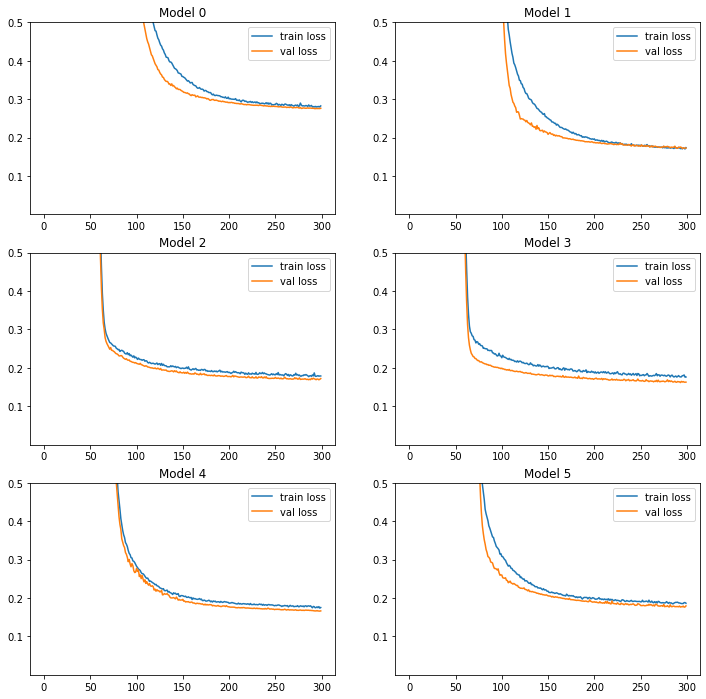

In [62]:
fib, axs = plt.subplots(3, 2, figsize=(12,12))

cnt = 0
for i in range(3):
    for j in range(2):
        axs[i,j].plot(models_train_hist[cnt][Scan.LUQ]['sparse_categorical_accuracy']) 
        axs[i,j].plot(models_train_hist[cnt][Scan.LUQ]['val_sparse_categorical_accuracy']) 
        axs[i,j].set_title(f'Model {cnt}')
        axs[i,j].set_ylim(0.0001, 0.5)
        axs[i,j].legend(['train loss','val loss'], loc='best')
        cnt += 1
    
    
plt.show()

In [ ]:
fib, axs = plt.subplots(3, 2, figsize=(12,12))

cnt = 0
for i in range(3):
    for j in range(2):
        axs[i,j].plot(models_train_hist[cnt][Scan.LUQ]['']) 
        axs[i,j].plot(models_train_hist[cnt][Scan.LUQ]['val_loss']) 
        axs[i,j].set_title(f'Model {cnt}')
        axs[i,j].set_ylim(0.0001, 0.5)
        axs[i,j].legend(['train loss','val loss'], loc='best')
        cnt += 1
    
    
plt.show()

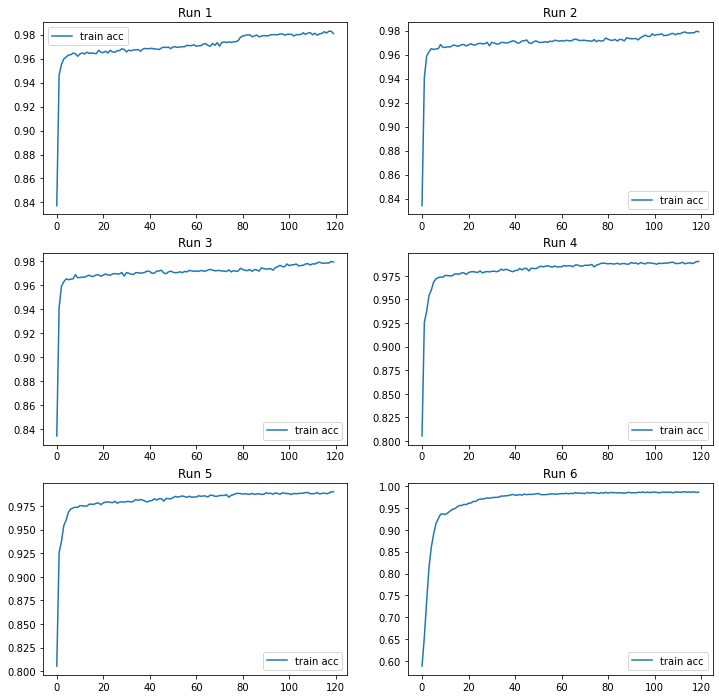

In [112]:
fib, axs = plt.subplots(3, 2, figsize=(12,12))

cnt = 1
for i in range(3):
    for j in range(2):
        axs[i,j].plot(models_train_hist[i + j]['sparse_categorical_accuracy']) 
        #axs[i,j].plot(models_train_hist[i + j]['val_loss'])
        axs[i,j].set_title(f'Run {cnt}')
        axs[i,j].legend(['train acc',], loc='best')
        cnt += 1
    
    
plt.show()
#fib.savefig('./dist_chars.png', bbox_inches='tight', pad_inches=0)


In [113]:
folds_stats_t = folds_stats

avg_acc = 0
for i in range(len(folds_stats_t)):
    avg_acc = avg_acc + folds_stats_t[i][1]
    if i == len(folds_stats_t) - 1:
        avg_acc = avg_acc / len(folds_stats_t)

avg_loss = 0
for i in range(len(folds_stats_t)):
    avg_loss = avg_loss + folds_stats_t[i][0]
    if i == len(folds_stats_t) - 1:
        avg_loss = avg_loss / len(folds_stats_t)

print(f'AVG test acc: {avg_acc}')
print(f'AVG testloss: {avg_loss}')
print(folds_stats_t)

AVG test acc: 0.9600923657417297
AVG testloss: 0.30058903495470685
[(0.31607112288475037, 0.9722483158111572), (0.30526989698410034, 0.975011944770813), (0.22233983874320984, 0.9788222908973694), (0.2447415292263031, 0.9757423400878906), (0.29798388481140137, 0.9506745934486389), (0.41712793707847595, 0.9080547094345093)]


In [25]:
print(models_train_hist.keys())
print(models_train_hist[0]['val_loss'])

dict_keys([0, 1, 2, 3, 4, 5])
[0.9097933769226074, 0.9089574813842773, 1.078664779663086, 0.9154428243637085, 1.1183348894119263, 0.9158821702003479, 1.0182151794433594, 0.9838638305664062, 1.1655361652374268, 1.0143007040023804, 1.0787535905838013, 1.0488659143447876, 1.0653297901153564, 1.0058845281600952, 0.9644420146942139, 1.0328338146209717, 1.0154310464859009, 1.0158318281173706, 1.0365582704544067, 1.0773814916610718, 0.9733935594558716, 0.9855836033821106, 1.0318691730499268, 1.2729917764663696, 1.0917859077453613, 0.9775439500808716, 1.0558056831359863, 1.0838241577148438, 0.9295015931129456, 1.0744441747665405, 1.0723634958267212, 1.079892635345459, 0.9361557364463806, 1.0354925394058228, 0.9304578900337219, 1.0865123271942139, 1.1827294826507568, 1.0616142749786377, 0.997739315032959, 1.1484628915786743, 0.9708570241928101, 1.0671703815460205, 1.1482462882995605, 1.0484932661056519, 1.1406890153884888, 1.0627474784851074, 0.9226558804512024, 1.1080304384231567, 1.1347999572

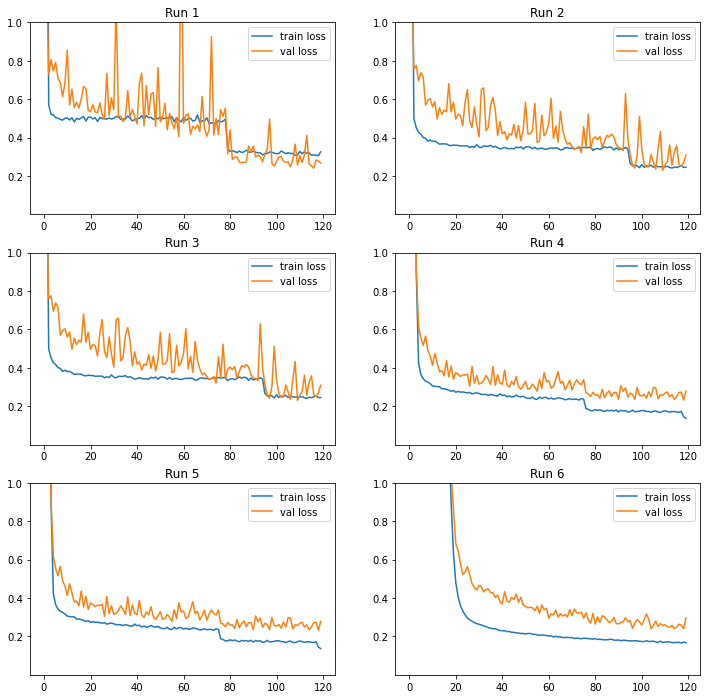

In [120]:
fib, axs = plt.subplots(3, 2, figsize=(12,12))

cnt = 1
for i in range(3):
    for j in range(2):
        axs[i,j].plot(models_train_hist[i + j]['loss']) 
        axs[i,j].plot(models_train_hist[i + j]['val_loss'])
        #print(f'MIN for {i + j} {np.min(models_train_hist[i + j]['val_loss'])}')
        axs[i,j].set_title(f'Run {cnt}')
        axs[i,j].set_ylim(0.0001, 1)
        axs[i,j].legend(['train loss', 'val loss',], loc='best')
        cnt += 1
    
    
plt.show()
#fib.savefig('./dist_chars.png', bbox_inches='tight', pad_inches=0)

In [ ]:
fib, axs = plt.subplots(3, 2, figsize=(12,12))

mean_train_loss = []
mean_val_loss = []

for i in range(folds_stats):
    for j in range(2):
        axs[i,j].plot(models_train_hist[i + j]['loss']) 
        axs[i,j].plot(models_train_hist[i + j]['val_loss'])
        print(f'MIN for {i + j} {np.min(models_train_hist[i + j]['val_loss'])}')
        axs[i,j].set_title(f'Run {cnt}')
        axs[i,j].legend(['train loss', 'val loss',], loc='best')
        cnt += 1
    
    
plt.show()
#fib.savefig('./dist_chars.png', bbox_inches='tight', pad_inches=0)

In [ ]:

y_pred = model.predict(X_test)
conf_mx = confusion_matrix(y_test, np.argmax(y_pred,axis=1))
print('Confusion matrix: \n{0}'.format(conf_mx))